# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

Увага! В цьому наборі завдань для простоти експериментів ми будемо спочатку робити векторизацію на всьому наборі даних, а потім розбивку на train i test. В робочих проєктах ми теж можемо використати цей підхід для швидшої побудови PoC (proof of concept). Але фінальне рішення, яке ми будемо деплоїти - треба проводити за правилом - спочатку розбивка на трейн і тест, потім пишемо обробку для трейну, навчаємо векторизатори. І потім використовуємо готові векторизатори для тесту і всіх даних на етапі передбачення (інференсу).

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv('train.csv')

In [29]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [30]:
df.dtypes

textID           object
text             object
selected_text    object
sentiment        object
dtype: object

In [31]:
df.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [32]:
df.drop(df[df['selected_text'].isnull()].index.values, inplace=True)

In [33]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



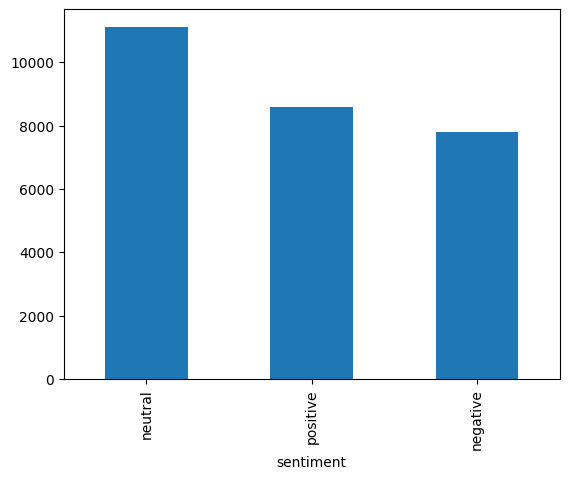

In [34]:
df['sentiment'].value_counts().plot(kind='bar')
plt.show()

In [94]:
df['text_length'] = df['selected_text'].apply(lambda x: len(x))

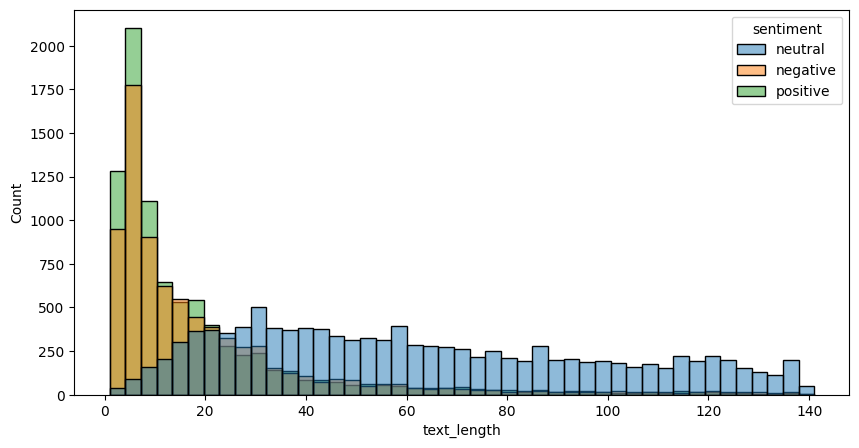

In [95]:
fig = plt.figure(figsize=(10,5))
sns.histplot(x=df['text_length'], hue=df['sentiment'])
plt.show()

Найбільше всього нейтральних твітів, також видно що в більшості випадків нейтральні твіти мають довжину від 40 символів. Позитивні та негативні твіти мають схожий розподіл

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [120]:
import nltk
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bilukhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bilukhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [109]:
stemmer = SnowballStemmer(language='english')
stopwords_set = set(stopwords.words('english'))

def process_text(sentence):
    # стеммінг + токенізація + фільтрація стопвордів
    text = ' '.join(stemmer.stem(word) for word in word_tokenize(sentence.lower()) if word not in stopwords_set)
    
    # видаляємо все що не літери + цифри
    text = ''.join(symbol for symbol in text if symbol in string.digits + string.ascii_lowercase + ' ').strip()
    return text
    
df['processed_text'] = df['text'].apply(lambda x: process_text(x))

In [113]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['processed_text'])

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [219]:
y_map = {"positive": 2, "neutral": 1, "negative": 0}
y = df['sentiment'].map(y_map)

X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [141]:
logreg = LogisticRegression(solver='liblinear')

logreg.fit(X_train_bow, y_train)
logreg_preds = logreg.predict(X_test_bow)

In [142]:
dectree = DecisionTreeClassifier()

dectree.fit(X_train_bow, y_train)
dectree_preds = dectree.predict(X_test_bow)

In [220]:
xgb = XGBClassifier()

xgb.fit(X_train_bow, y_train)
xgb_preds = xgb.predict(X_test_bow)

In [168]:
print("---------------- Logistic Regression ----------------")
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, logreg_preds)))
print("F1 score: {:.2f}%".format(100 * f1_score(y_test, logreg_preds, average='macro')))

print("---------------- Decision Tree Classifier ----------------")
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, dectree_preds)))
print("Accuracy: {:.2f}%".format(100 * f1_score(y_test, dectree_preds, average='macro')))

print("---------------- XGB Classifier ----------------")
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, xgb_preds)))
print("Accuracy: {:.2f}%".format(100 * f1_score(y_test, xgb_preds, average='macro')))

---------------- Logistic Regression ----------------
Accuracy: 68.92%
F1 score: 68.89%
---------------- Decision Tree Classifier ----------------
Accuracy: 66.10%
Accuracy: 66.05%
---------------- XGB Classifier ----------------
Accuracy: 70.16%
Accuracy: 69.64%


### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [192]:
feature_importance_logreg = pd.Series(logreg.coef_[0], index=vectorizer.get_feature_names_out(), name='importance').sort_values(ascending=False)
feature_importance_dectree = pd.Series(dectree.feature_importances_, index=vectorizer.get_feature_names_out(), name='importance').sort_values(ascending=False)
feature_importance_xgb = pd.Series(xgb.feature_importances_, index=vectorizer.get_feature_names_out(), name='importance').sort_values(ascending=False)

In [200]:
feature_importance_logreg[:10]

sad        3.116958
suck       3.026100
bore       2.748442
fail       2.735232
hate       2.668533
headach    2.659304
miss       2.612107
stupid     2.601833
wtf        2.553196
sorri      2.551220
Name: importance, dtype: float64

In [201]:
feature_importance_dectree[:10]

love     0.025843
happi    0.024087
thank    0.023281
good     0.018662
miss     0.015697
sad      0.014463
great    0.011100
sorri    0.010540
nice     0.009984
hate     0.009980
Name: importance, dtype: float64

In [202]:
feature_importance_xgb[:10]

thank     0.017357
happi     0.016043
hate      0.010499
suck      0.009886
nice      0.009216
love      0.009087
awesom    0.009027
amaz      0.008848
ugh       0.008632
sad       0.008219
Name: importance, dtype: float32

Цікаво що усі 3 моделі показали різні важливості слів, для прикладу, логістична регресія показує що найбільші коефіцієнти мають саме негативні слова, при чому акцент саме на образах. Decision tree найважливішими виділила загальні слова окрасу сентименту, а XGB класифікатор акцентував увагу саме на зверненнях, на фразах користувачів. Важливості усіх 3 моделей мають місце бути

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [211]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['processed_text'])

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [212]:
logreg = LogisticRegression(solver='liblinear')

logreg.fit(X_train_tfidf, y_train)
logreg_preds = logreg.predict(X_test_tfidf)

dectree = DecisionTreeClassifier()

dectree.fit(X_train_tfidf, y_train)
dectree_preds = dectree.predict(X_test_tfidf)

xgb = XGBClassifier()

xgb.fit(X_train_tfidf, y_train)
xgb_preds = xgb.predict(X_test_tfidf)

In [213]:
print("---------------- Logistic Regression ----------------")
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, logreg_preds)))
print("F1 score: {:.2f}%".format(100 * f1_score(y_test, logreg_preds, average='macro')))

print("---------------- Decision Tree Classifier ----------------")
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, dectree_preds)))
print("Accuracy: {:.2f}%".format(100 * f1_score(y_test, dectree_preds, average='macro')))

print("---------------- XGB Classifier ----------------")
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, xgb_preds)))
print("Accuracy: {:.2f}%".format(100 * f1_score(y_test, xgb_preds, average='macro')))

---------------- Logistic Regression ----------------
Accuracy: 68.52%
F1 score: 68.17%
---------------- Decision Tree Classifier ----------------
Accuracy: 65.96%
Accuracy: 65.94%
---------------- XGB Classifier ----------------
Accuracy: 69.87%
Accuracy: 69.30%


In [214]:
feature_importance_logreg = pd.Series(logreg.coef_[0], index=vectorizer.get_feature_names_out(), name='importance').sort_values(ascending=False)
feature_importance_dectree = pd.Series(dectree.feature_importances_, index=vectorizer.get_feature_names_out(), name='importance').sort_values(ascending=False)
feature_importance_xgb = pd.Series(xgb.feature_importances_, index=vectorizer.get_feature_names_out(), name='importance').sort_values(ascending=False)

In [215]:
feature_importance_logreg[:10]

sad       7.408734
miss      7.076253
suck      6.074445
hate      6.068248
sorri     5.803565
bore      5.172396
fail      4.904311
hurt      4.770172
stupid    4.681702
sick      4.635930
Name: importance, dtype: float64

In [216]:
feature_importance_dectree[:10]

love     0.027027
happi    0.024837
thank    0.024330
good     0.021214
miss     0.017047
sad      0.014663
sorri    0.011489
great    0.011459
hope     0.010551
nice     0.010338
Name: importance, dtype: float64

In [217]:
feature_importance_xgb[:10]

thank     0.015706
happi     0.014955
awesom    0.009681
suck      0.008850
amaz      0.008341
hate      0.008195
great     0.007982
nice      0.007965
bore      0.007883
love      0.007860
Name: importance, dtype: float32

Цікаво, що для BOW моделі показали кращі коефіцієнти важливості, хоча для обох випадків і для BOW і для TF-IDF, слова мають відносно схожі важливості. Я б обрав би BOW через кращі показники Accuracy та F1-score

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [222]:
df['y_pred'] = xgb.predict(X)
df['y'] = y

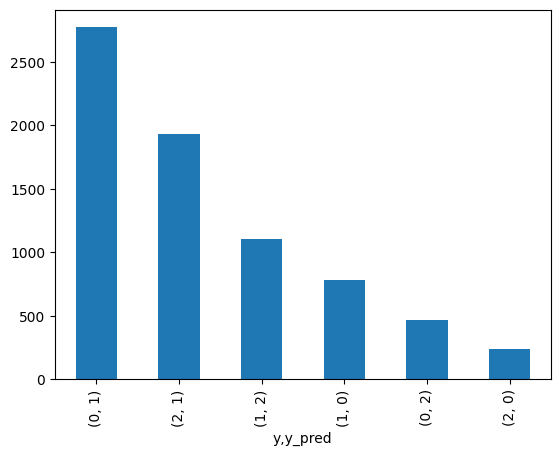

In [230]:
df[df['y'] != df['y_pred']][['y', 'y_pred']].value_counts().plot(kind='bar')
plt.show()

In [233]:
df[(df['y'] == 0) & (df['y_pred'] == 1)]

,textID,text,selected_text,sentiment,text_length,processed_text,y,y_pred
2,088c60f138,my boss is bullying me...,bullying me,negative,11,boss bulli,0,1
3,9642c003ef,what interview! leave me alone,leave me alone,negative,14,interview leav alon,0,1
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,13,son put releas alreadi bought,0,1
12,74a76f6e0a,My Sharpie is running DANGERously low on ink,DANGERously,negative,11,sharpi run danger low ink,0,1
16,3440297f8b,"S`ok, trying to plot alternatives as we speak...",*sigh*,negative,6,ok tri plot altern speak sigh,0,1
...,...,...,...,...,...,...,...,...
27438,9057950ae4,Where is my bestie when i need him,Where is my bestie when i need him,negative,34,besti need,0,1
27439,ecfc3c4122,I am beginning to think sun blcok is a haox.,haox.,negative,5,begin think sun blcok haox,0,1
27440,7fd422900b,I GET IT. YOU ESPLAINED IT TO ME AWHILE AGO.,I GET IT.,negative,9,get esplain awhil ago,0,1
27456,d32efe060f,i wanna leave work already! Not feelin it 2day,wanna leave work al,negative,19,wan na leav work alreadi feelin 2day,0,1


Класифікатор найбільше помиляється на визначенні негативного класу. Він в більшості помилково вважає що негативний клас є нейтральним.
* 1 покращення: враховувати регістр. Помітив, що саме виділені слова у верхньому регістрі могли допомогти підсвітити контекст
* 2 покращення: додати до класифікатора довжину тексту, так як нейтральні коментарі мають довшу довжину
* 3 покращення: n-grams додати найбільш повторювані n грами для слів позитивного та негативного класів

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model